# Controlling a Mouse with EMG Signals

In [3]:
import threading
import serial
import time
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import pyautogui
import pandas as pd
import pickle
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPool1D
from tensorflow.keras.models import load_model
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

from bitstring import BitArray

from collections import deque

from tqdm import tqdm

# Data Collection

In [2]:
# setting up lists to record into
num_channel = 4

mouse_data = []

mouse_times = []

muscle_times = []

muscle_data = []

In [3]:
#  function to record mouse positions and time of recordings
    
def measure_mouse():
        
    while run:
            
        mouse_times.append(time.time())
            
        mouse_data.append(pyautogui.position())
            
            

# Function to record raw serial data and time of recordings            
            
def measure_muscle():
        
    ser = serial.Serial('COM4', 230400)
    while run:
            
        muscle_times.append(time.time())

        muscle_data.append(self.ser.read(1))
            


In [5]:
# running recording functions semi simultaneously on two threads 

run = True
lock = threading.Lock()

t1 = threading.Thread(target=measure_muscle,)
t2 = threading.Thread(target=measure_mouse,)


t1.start(), t2.start()


time.sleep(60)

run = False

t1.join(), t2.join()


(None, None)

In [6]:
# converting bytes in muscle data to binary strings 
muscle_data = [BitArray(val).bin for val in muscle_data]

In [7]:
len(mouse_data), len(muscle_data)

(3486727, 980323)

In [8]:
# setting up mouse and muscle dataframes

mouse = pd.DataFrame({'mouse_pos':mouse_data, 'mouse_time':mouse_times})
muscle = pd.DataFrame({'muscle_data':muscle_data, 'muscle_time':muscle_times})

# Data Pre-Processing

In [9]:
# counting frames in muscle data
count = 0
for val in muscle['muscle_data']:
   
    if int(val[0]):
        break
    else:
        pass
    count += 1
muscle = muscle[count:].reset_index(drop=True)

In [11]:
# converting binary string to list of frames and converting individual times to time ranges

frames = []
time_ranges = []
for i, val in enumerate(muscle['muscle_data']):
    if bool(int(val[0])):
        frames.append(muscle['muscle_data'][i:i+num_channel*2])
        try:
            time_ranges.append([muscle['muscle_time'][i], muscle['muscle_time'][i + num_channel * 2]])
        except:
            time_ranges.append(None)
    else:
        pass

In [12]:
# making frame vals lists
frames = [list(val) for val in frames]

In [13]:
frames = frames[1:]
time_ranges = time_ranges[1:]

In [14]:
# updating muscle data frame with time ranges and mucle frames
muscle = pd.DataFrame({'muscle_data':frames, 'muscle_time_ranges':time_ranges})

In [15]:
# peeking at data

display(muscle.head())
mouse.head()

,muscle_data,muscle_time_ranges
0,"[10000001, 00111111, 00000000, 00010011, 00000...","[1583721071.0505328, 1583721071.0515368]"
1,"[10000000, 00010110, 00000000, 00100000, 00000...","[1583721071.0515368, 1583721071.0525389]"
2,"[10000000, 00010110, 00000000, 00011111, 00000...","[1583721071.0525389, 1583721071.0525389]"
3,"[10000000, 00010110, 00000000, 00011111, 00000...","[1583721071.0525389, 1583721071.0525389]"
4,"[10000000, 00010101, 00000000, 00011111, 00000...","[1583721071.0525389, 1583721071.0525389]"


,mouse_pos,mouse_time
0,"(2044, 911)",1.583721e+09
1,"(2044, 911)",1.583721e+09
2,"(2044, 911)",1.583721e+09
3,"(2044, 911)",1.583721e+09
4,"(2044, 911)",1.583721e+09


In [16]:
# removing duplicate mouse recordings
mouse.drop_duplicates(inplace = True)

In [17]:
# down sampling mouse data to match muscle data

down_sampled_mouse = []

for val in tqdm(muscle['muscle_time_ranges']):
    mouse = mouse[mouse['mouse_time'] >= val[0]]
    
    down_sampled_mouse.append(list(mouse['mouse_pos'])[0])
        
#     except:
#         down_sampled_mouse.append([None, None])
#     for i in range(len(mouse)):
#         if mouse['mouse_time'][i] >= val[0]:
#             down_sampled_mouse.append(mouse['mouse_pos'][i])
#             break
#         else:
#             mouse.drop(i, inplace=True)
    

100%|█████████▉| 122396/122538 [27:48<00:00, 1543.73it/s]

TypeError: 'NoneType' object is not subscriptable

In [18]:
# checking lengths of muscle and mouse
len(down_sampled_mouse), len(muscle)

(122537, 122538)

In [19]:
down_sampled_mouse.append([None, None])

In [20]:
# creating final dataframe
df = muscle
df['mouse_pos'] = down_sampled_mouse

100%|█████████▉| 122396/122538 [28:01<00:00, 1543.73it/s]

In [21]:
# turning pyautogui points into two seperate columns for export

df['x_pos'] = ([val[0] for val in df['mouse_pos']])
df['y_pos'] = ([val[1] for val in df['mouse_pos']])

    
df.drop(columns = 'mouse_pos', inplace = True)


In [22]:
df.drop(columns='muscle_time_ranges', inplace=True)

In [23]:
# seperating muscle data into seperate channels
df['channel_1'] = [val[:2] for val in df['muscle_data']]
df['channel_2'] = [val[2:4] for val in df['muscle_data']]
df['channel_3'] = [val[4:6] for val in df['muscle_data']]
df['channel_4'] = [val[6:8] for val in df['muscle_data']]



In [24]:
df.drop(columns='muscle_data', inplace=True)

In [25]:
df.dropna(inplace=True)

In [26]:
df.head()

,x_pos,y_pos,channel_1,channel_2,channel_3,channel_4
0,2272.0,659.0,"[10000001, 00111111]","[00000000, 00010011]","[00000000, 00000000]","[00000000, 01010011]"
1,2268.0,661.0,"[10000000, 00010110]","[00000000, 00100000]","[00000000, 00000000]","[00000000, 01010011]"
2,2265.0,664.0,"[10000000, 00010110]","[00000000, 00011111]","[00000000, 00001100]","[00000000, 01010011]"
3,2265.0,664.0,"[10000000, 00010110]","[00000000, 00011111]","[00000000, 00010000]","[00000000, 01101111]"
4,2265.0,664.0,"[10000000, 00010101]","[00000000, 00011111]","[00000000, 00010000]","[00000000, 01101111]"


In [27]:
# making function to turn list of binary strings into integers
def raw_to_num(channel, is_first):
    if is_first:
        
        channel[0] = '0' + channel[0][1:]
  
    channel = channel[0] + channel[1]
    
    channel = int(channel, 2)
    
    return(channel)

In [28]:
# appling raw to num to all channels
df['channel_1'] = [raw_to_num(val, True) for val in df['channel_1']]
df['channel_2'] = [raw_to_num(val, False) for val in df['channel_2']]
df['channel_3'] = [raw_to_num(val, False) for val in df['channel_3']]
df['channel_4'] = [raw_to_num(val, False) for val in df['channel_4']]

In [29]:
# checking data one last time
df

,x_pos,y_pos,channel_1,channel_2,channel_3,channel_4
0,2272.0,659.0,319,19,0,83
1,2268.0,661.0,22,32,0,83
2,2265.0,664.0,22,31,12,83
3,2265.0,664.0,22,31,16,111
4,2265.0,664.0,21,31,16,111
...,...,...,...,...,...,...
122532,1577.0,1148.0,13,28,6,351
122533,1577.0,1148.0,13,28,6,351
122534,1581.0,1148.0,13,28,6,351
122535,1581.0,1148.0,13,28,6,350


In [30]:
# saving data
df.to_csv('data/raw_recording_2.csv', index=False)

# Exploratory Data Analysis

In [3]:
# loading in data

df = pd.read_csv('data/raw_recording_1.csv',dtype={'muscle_data':object})
df.head()

,x_pos,y_pos,channel_1,channel_2,channel_3,channel_4
0,2272.0,659.0,319,19,0,83
1,2268.0,661.0,22,32,0,83
2,2265.0,664.0,22,31,12,83
3,2265.0,664.0,22,31,16,111
4,2265.0,664.0,21,31,16,111


In [4]:
# making columns that will be predicted on

df['x_diff'] = df['x_pos'].diff()
df['y_diff'] = df['y_pos'].diff()
df.dropna(inplace=True)

In [5]:
df.head()

,x_pos,y_pos,channel_1,channel_2,channel_3,channel_4,x_diff,y_diff
1,2268.0,661.0,22,32,0,83,-4.0,2.0
2,2265.0,664.0,22,31,12,83,-3.0,3.0
3,2265.0,664.0,22,31,16,111,0.0,0.0
4,2265.0,664.0,21,31,16,111,0.0,0.0
5,2265.0,664.0,21,31,16,11,0.0,0.0


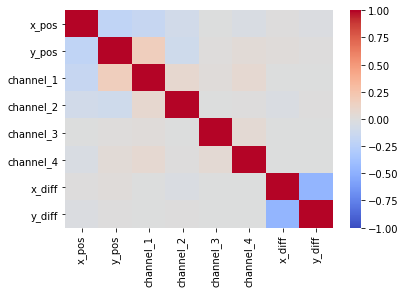

In [6]:
# using heatmap to visualize correlations
sns.heatmap(df.corr(), cmap='coolwarm', vmin=-1)

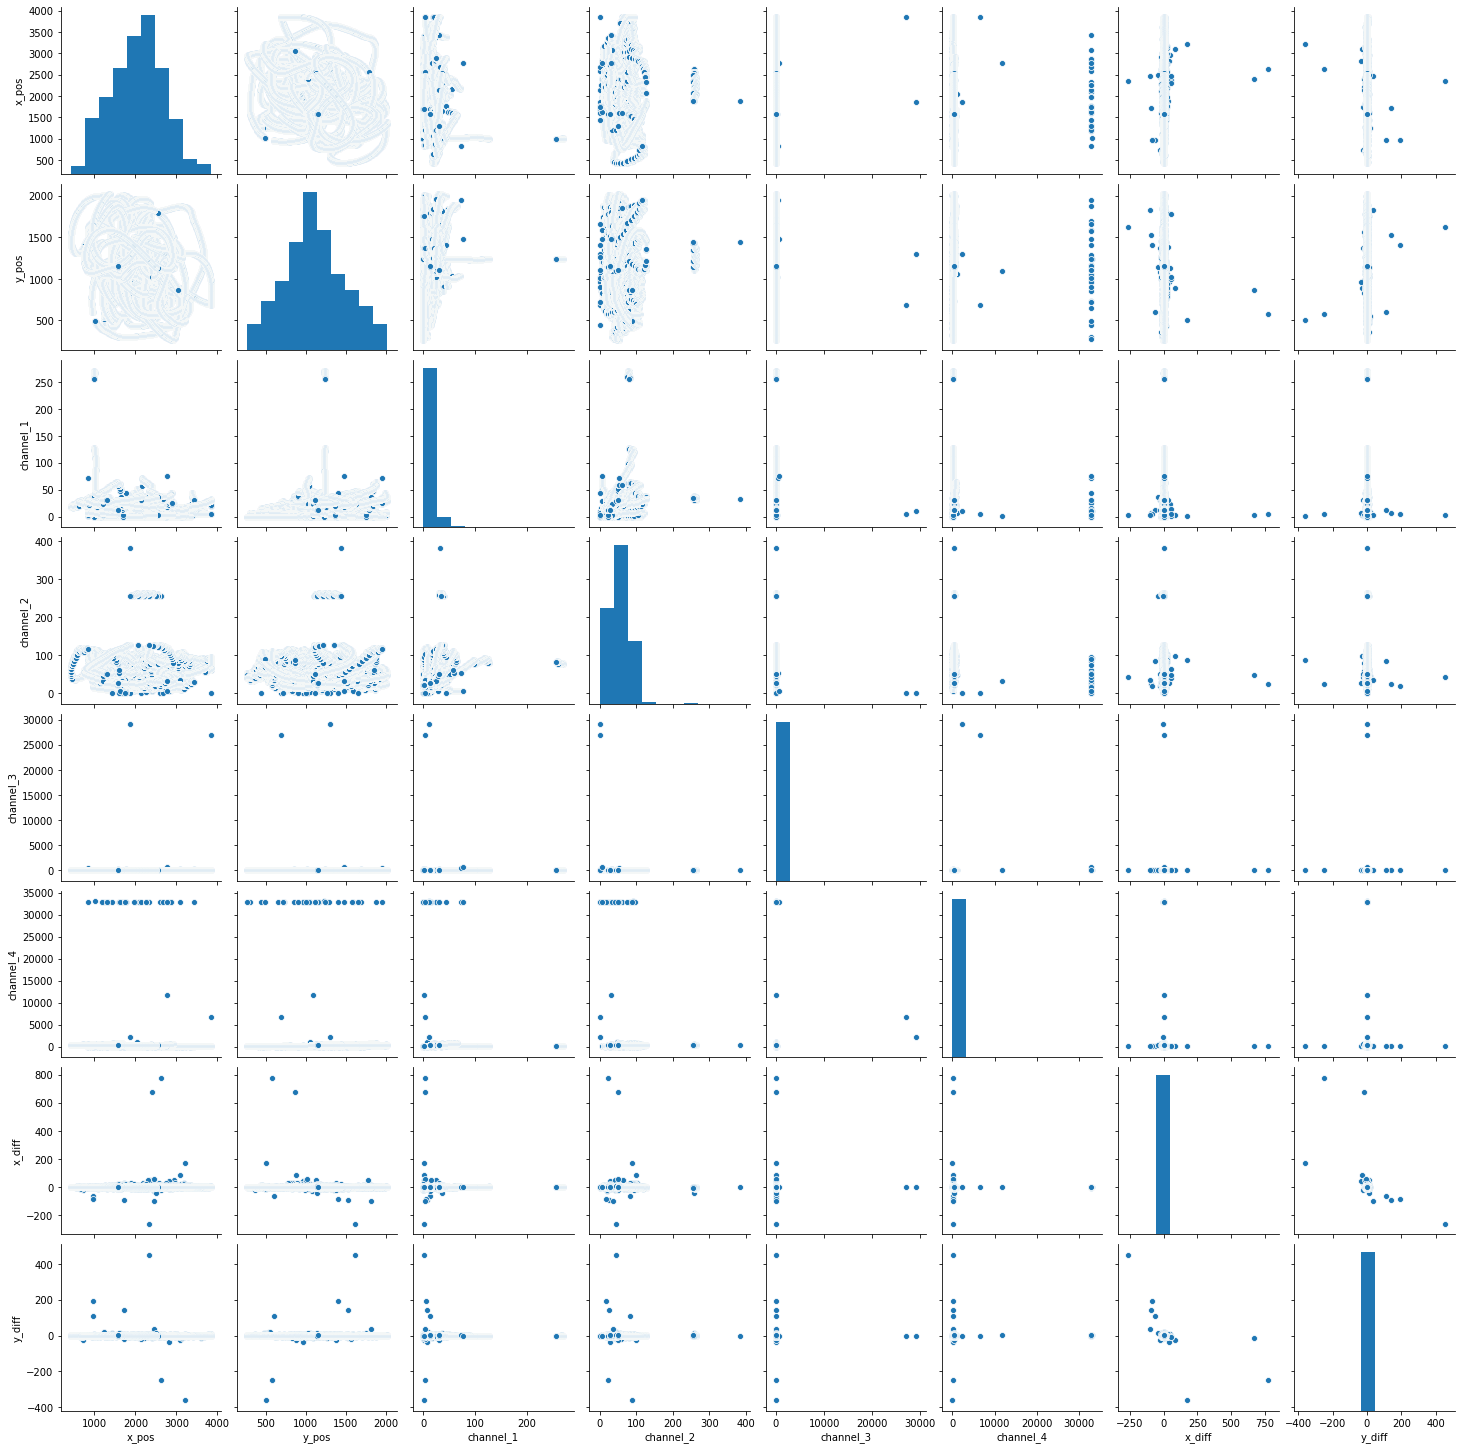

In [7]:
# usning pairplot to visualize correlations and distributions
sns.pairplot(df)

In [7]:
# plotting channels and differences in mouse postions


plt.figure(figsize=(200,200))

plt.plot(df['channel_1'])
plt.plot(df['channel_2'])
plt.plot(df['channel_3'])
plt.plot(df['channel_4'])

plt.plot(df['x_diff'])
plt.plot(df['y_diff'])

# Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

import pickle

In [2]:
df = pd.read_csv('../data/raw_recording_1.csv')
df

,x_pos,y_pos,channel_1,channel_2,channel_3,channel_4
0,2272.0,659.0,319,19,0,83
1,2268.0,661.0,22,32,0,83
2,2265.0,664.0,22,31,12,83
3,2265.0,664.0,22,31,16,111
4,2265.0,664.0,21,31,16,111
...,...,...,...,...,...,...
122532,1577.0,1148.0,13,28,6,351
122533,1577.0,1148.0,13,28,6,351
122534,1581.0,1148.0,13,28,6,351
122535,1581.0,1148.0,13,28,6,350


In [3]:
# df.drop(columns=['time', 'start', 'end'], inplace=True)

In [4]:
for i in range(10000,10500):

    df[f'channel_1_{i}'] = df['channel_1'].shift(i)
    df[f'channel_2_{i}'] = df['channel_2'].shift(i)
    df[f'channel_3_{i}'] = df['channel_3'].shift(i)
    df[f'channel_4_{i}'] = df['channel_4'].shift(i)

In [5]:
df['x_diff'] = df['x_pos'].diff()
df['y_diff'] = df['y_pos'].diff()

In [6]:
df.dropna(inplace=True)

In [7]:
X = df.drop(columns=['x_pos', 'y_pos', 'x_diff', 'y_diff'])
y = list(df['x_diff'])

W = X
z = list(df['y_diff'])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False)
W_train, W_test, z_train, z_test = train_test_split(W, z, shuffle = False)

In [9]:
lr_x = DecisionTreeRegressor(max_depth=50)
lr_x.fit(X_train, y_train)

lr_y = DecisionTreeRegressor(max_depth=50)
lr_y.fit(W_train, z_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=50,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [10]:
lr_x.score(X_train, y_train), lr_x.score(X_test, y_test)

(0.9956499916675465, -1.9827793231664756)

In [11]:
lr_y.score(W_train, z_train), lr_y.score(W_test, z_test)

(0.9927989543655756, -1.6157710029325512)

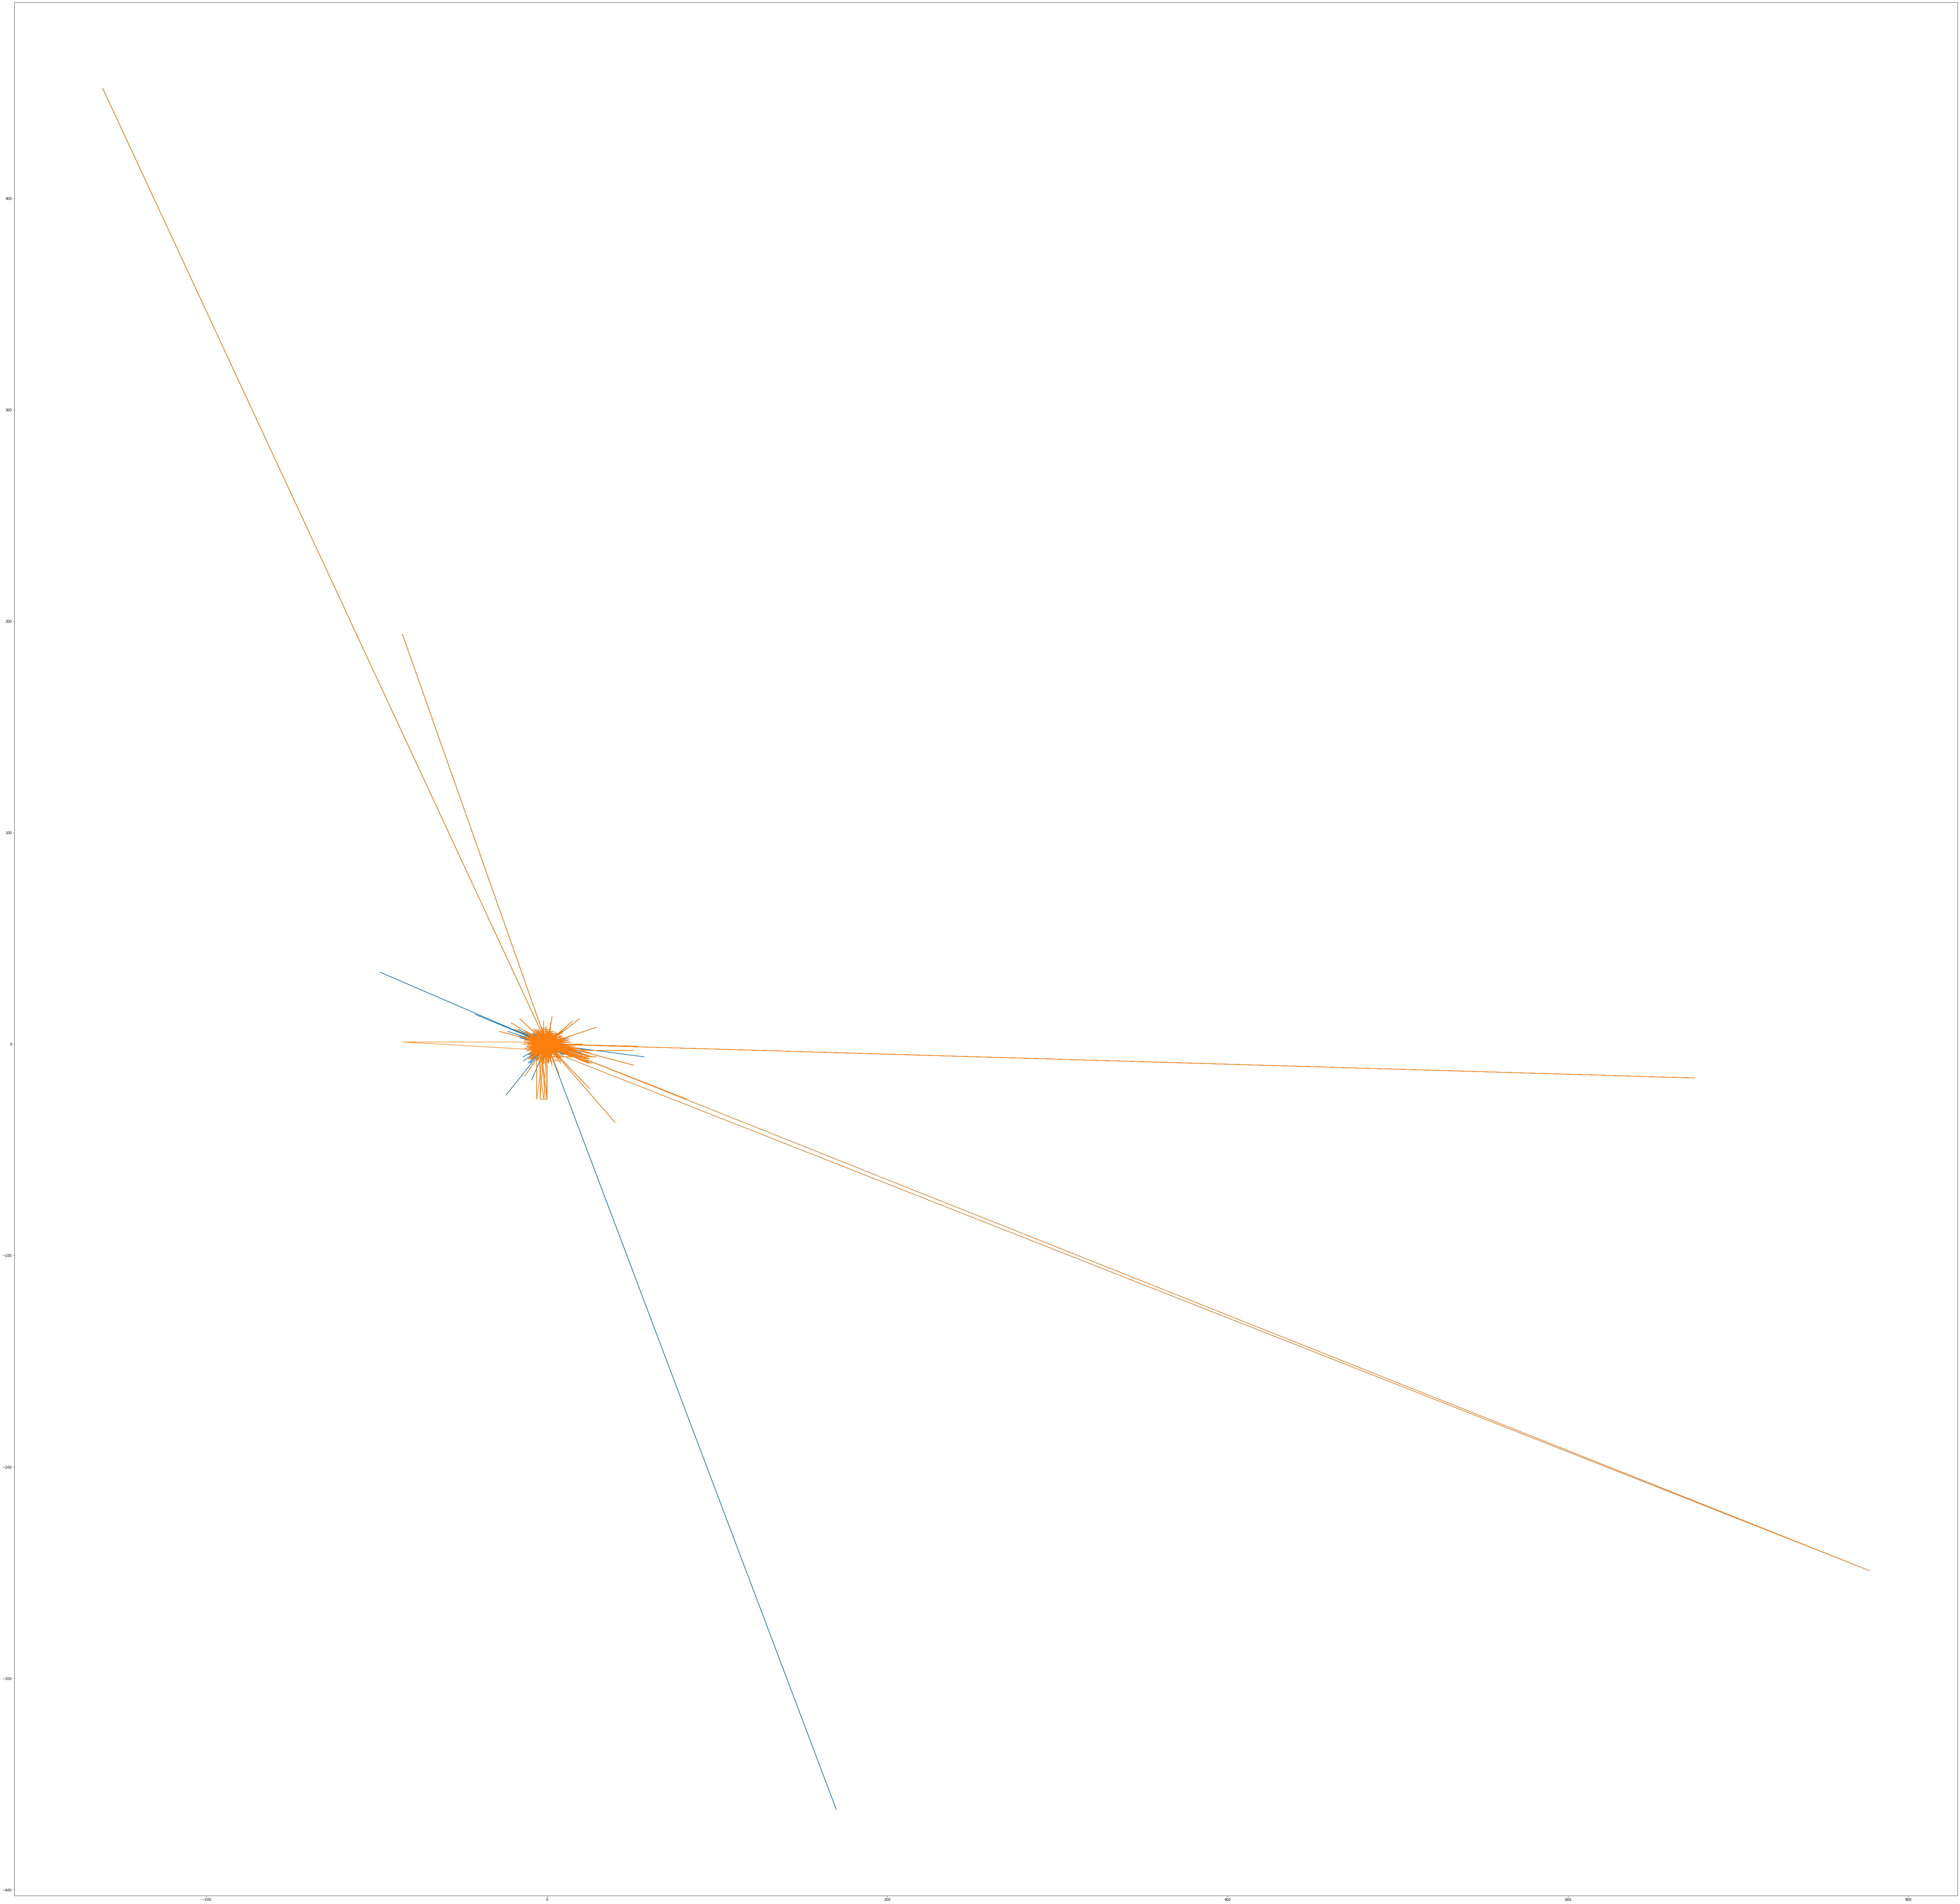

In [12]:
plt.figure(figsize=(100,100))
plt.plot(y, z);
plt.plot(lr_x.predict(X), lr_y.predict(W));


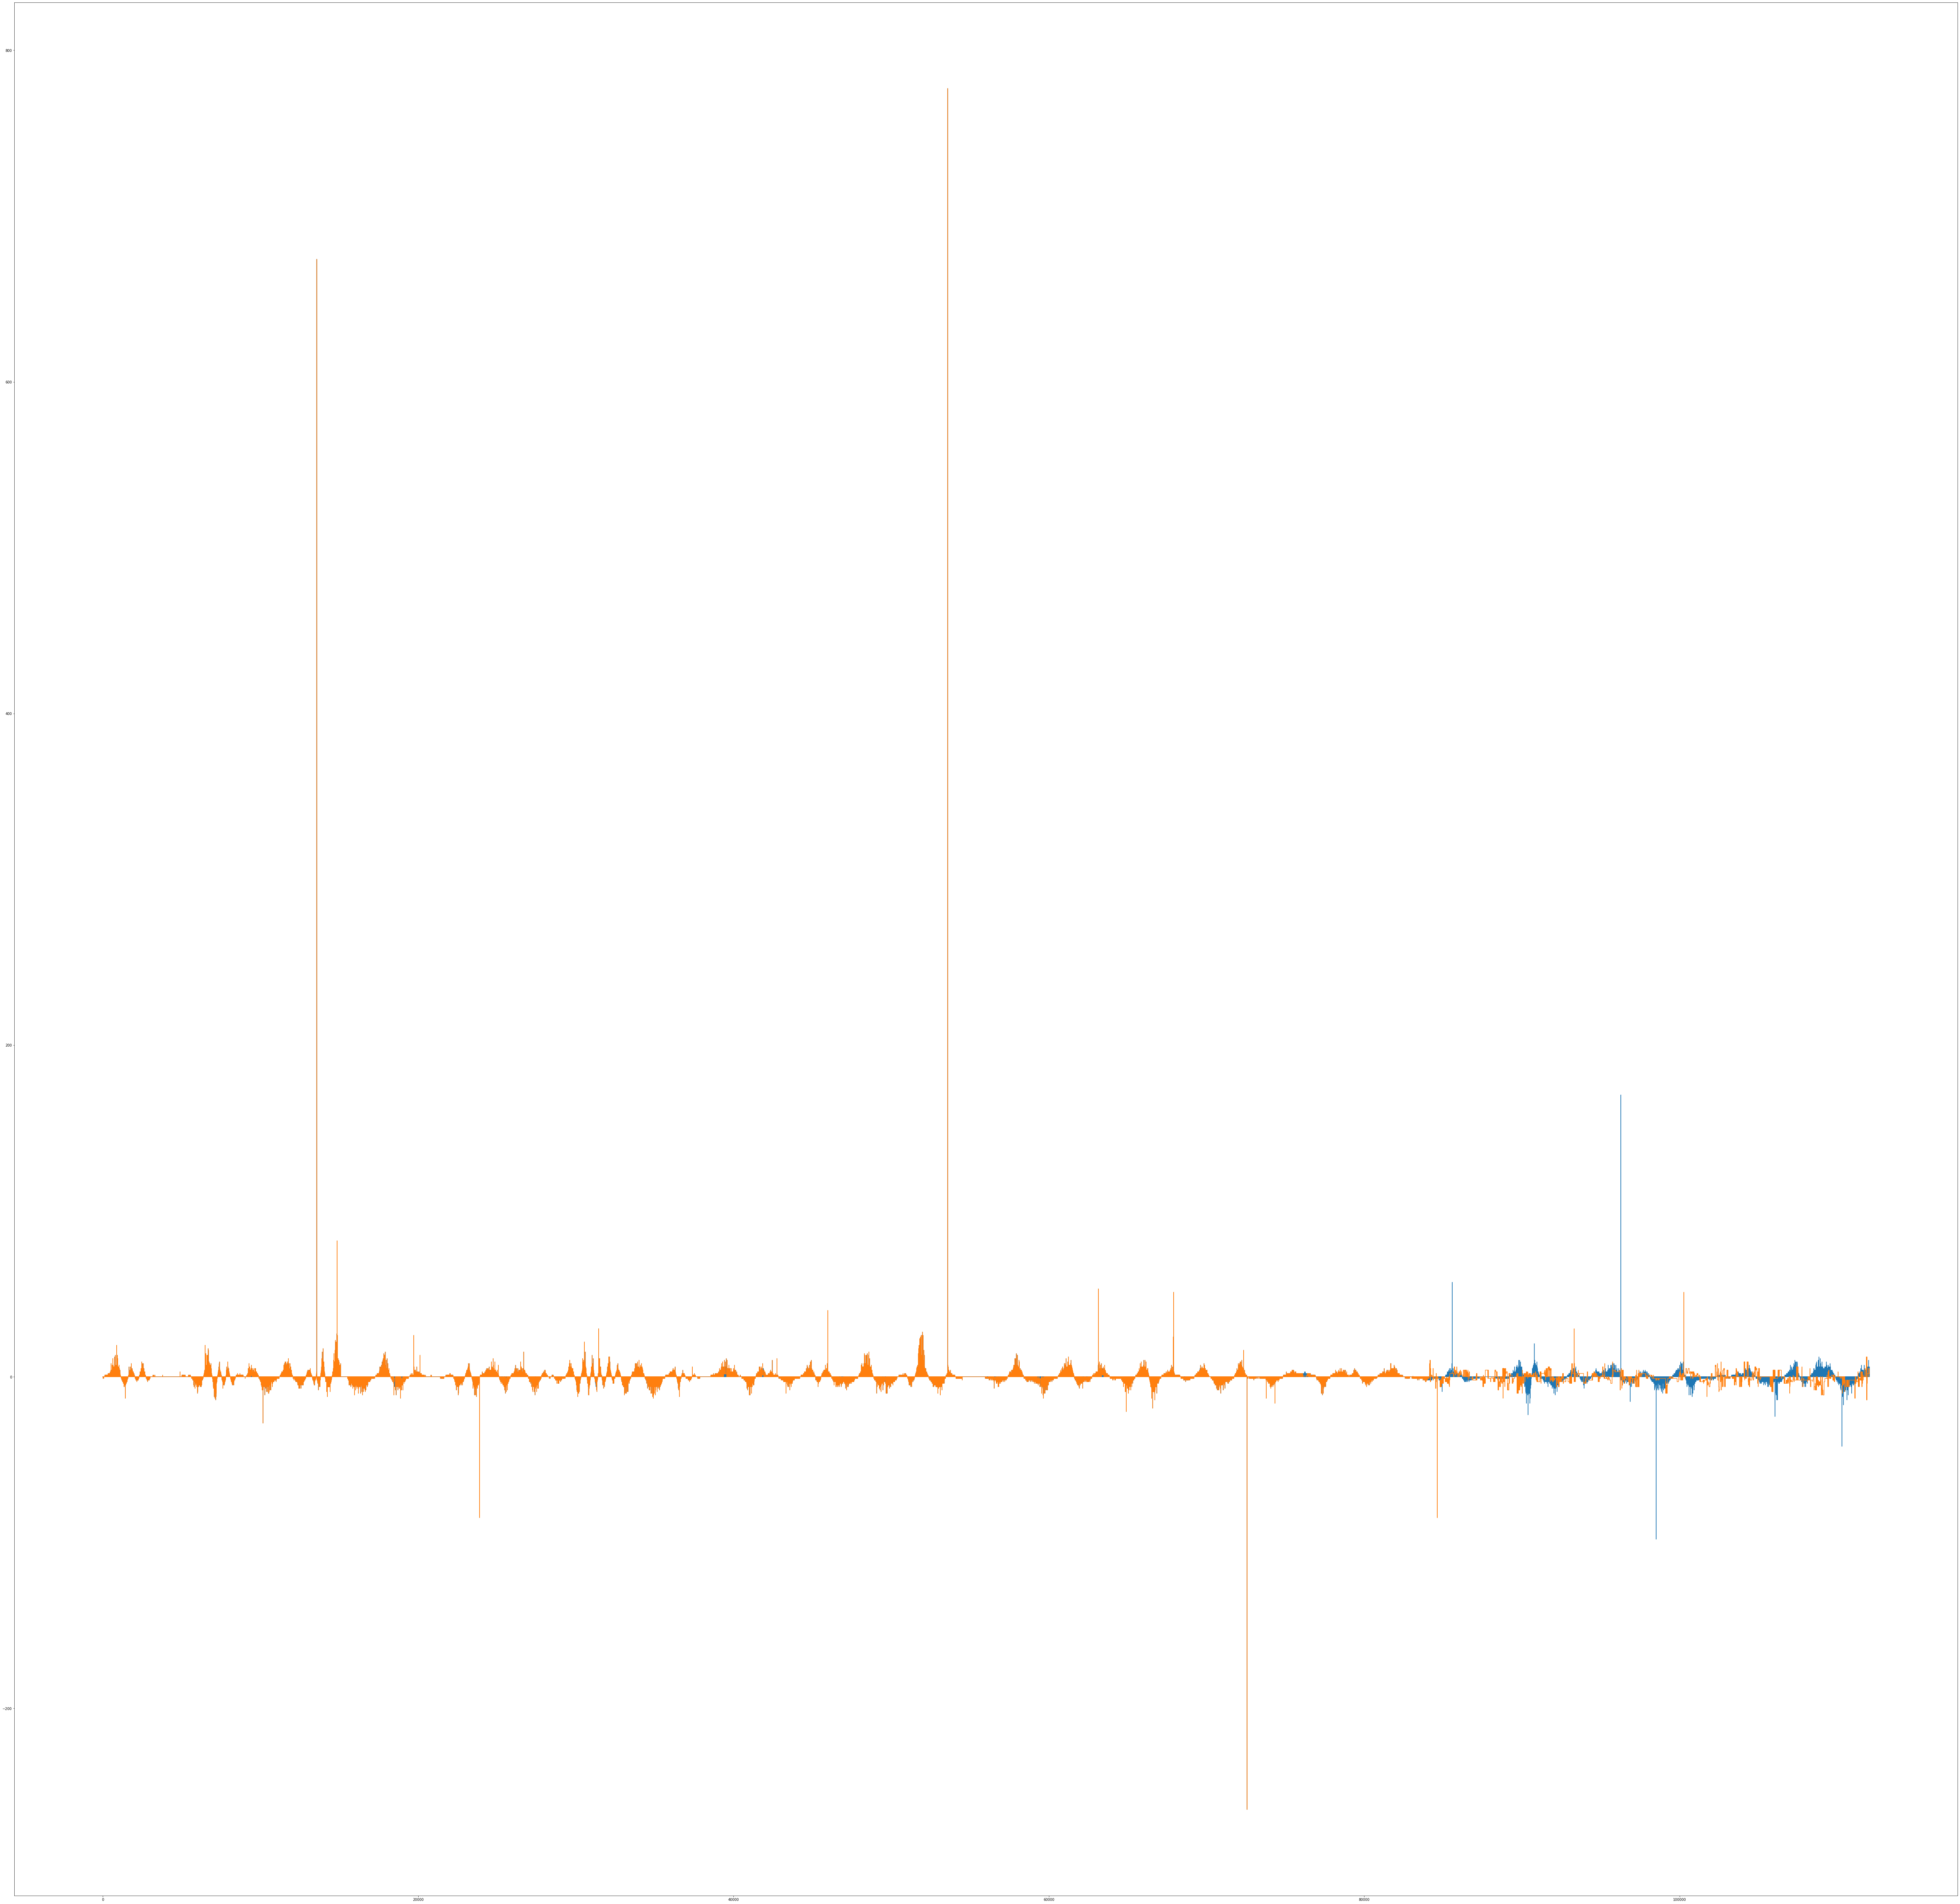

In [16]:
plt.figure(figsize=(100,100))
plt.plot(y);
plt.plot(lr_x.predict(X));


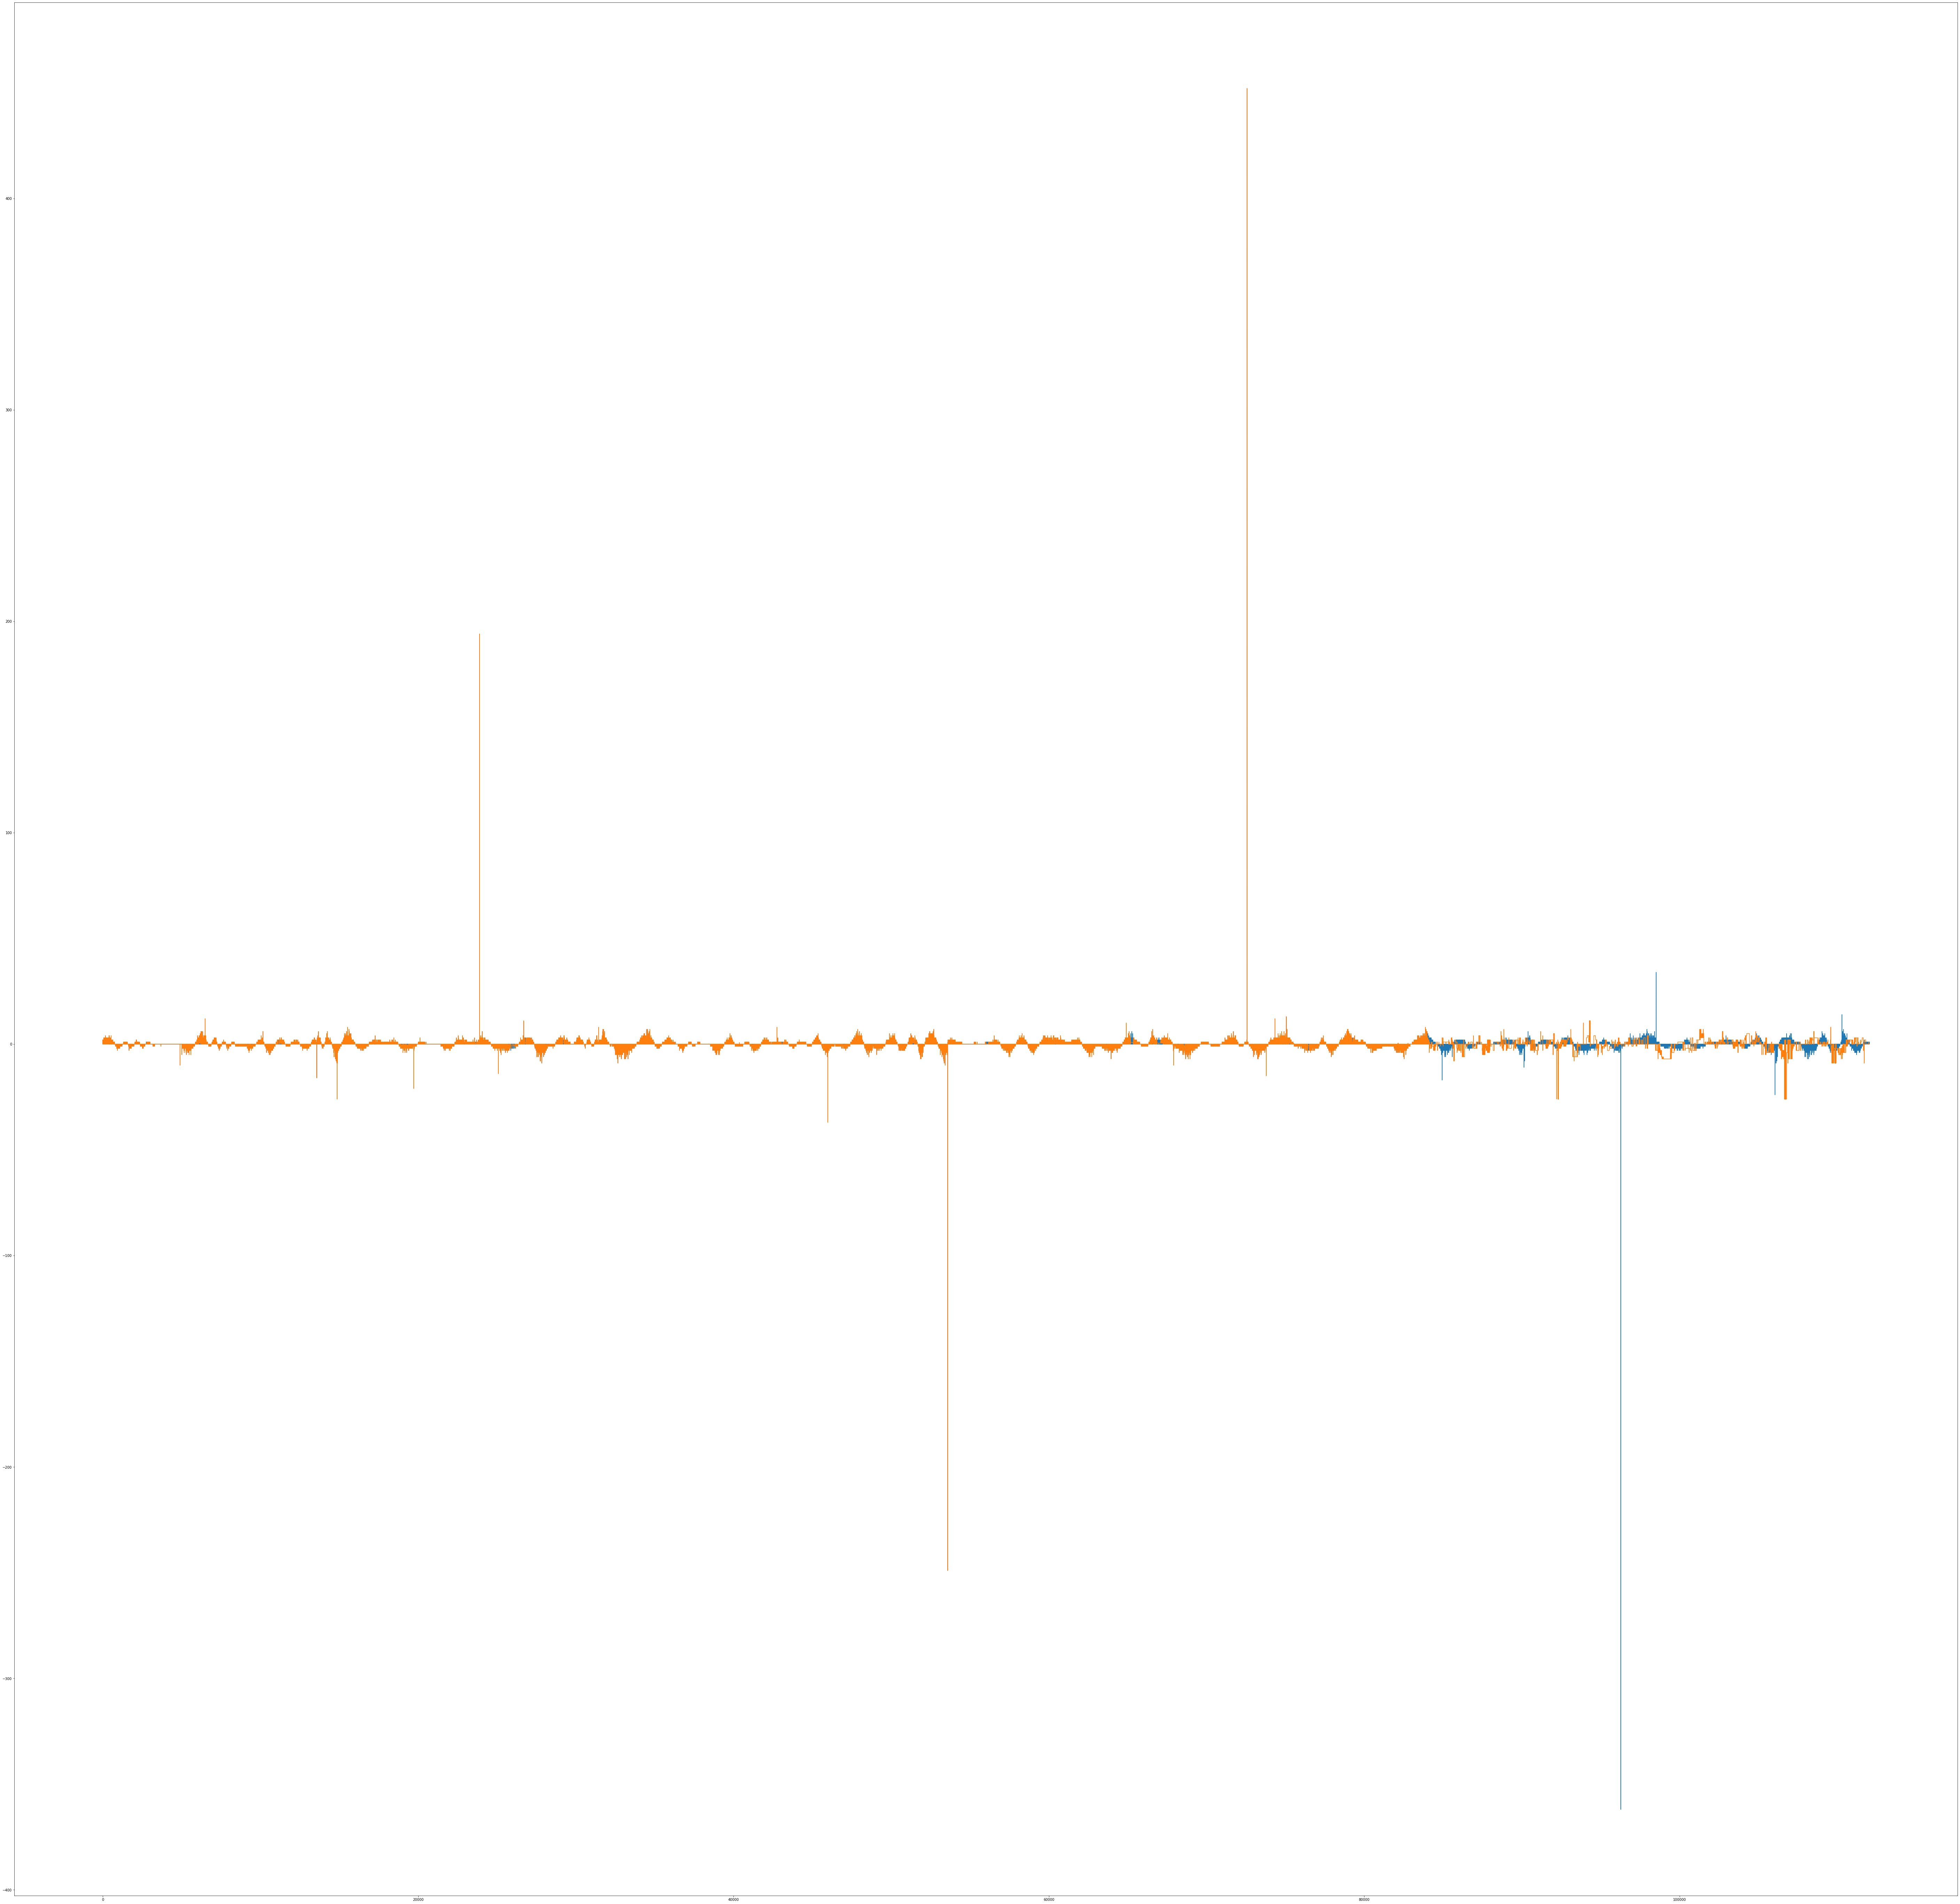

In [14]:
plt.figure(figsize=(100,100))
plt.plot(z);
plt.plot(lr_y.predict(W));


In [15]:
with open('../pickled_models/dt_x.pkl', 'wb') as f:
    pickle.dump(lr_x, f)


with open('../pickled_models/dt_y.pkl', 'wb') as f:
    pickle.dump(lr_y, f)


# Implementation

In [2]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# loading neural net
nn_pos = load_model('pickled_models/pos_nn/')
nn_pos._make_predict_function()
global graph
graph = tf.get_default_graph()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [4]:
# leading adaboost model
with open('pickled_models/adaboost_x.pkl', 'rb') as f:
    
    ab_x = pickle.load(f,)

with open('pickled_models/adaboost_y.pkl', 'rb') as f:
    
    ab_y = pickle.load(f)

In [5]:
# loading random forest model
with open('pickled_models/rf_x.pkl', 'rb') as f:
    
    rf_x = pickle.load(f,)

with open('pickled_models/rf_y.pkl', 'rb') as f:
    
    rf_y = pickle.load(f)

In [6]:
# loading linear regression model
with open('pickled_models/linear_x.pkl', 'rb') as f:
    
    lr_x = pickle.load(f,)

with open('pickled_models/linear_y.pkl', 'rb') as f:
    
    lr_y = pickle.load(f)

In [7]:
# loading decision tree model
with open('pickled_models/dt_x.pkl', 'rb') as f:
    
    dt_x = pickle.load(f,)

with open('pickled_models/dt_y.pkl', 'rb') as f:
    
    dt_y = pickle.load(f)

In [8]:
# setting up recording parameters and deques to record into

num_channel = 4

gain = 1

muscle_data = deque(maxlen = 500*num_channel + 994)

simple_muscle_data = deque(maxlen = 500*num_channel)

to_predict = deque()

current = deque()


In [10]:
# a function that recording muscle data mouse position and stores it in a complex deque
def measure_muscle():
    ser = serial.Serial('COM4', 230400)
    global muscle_data
    global to_predict
#     global current
    while run:
        first = ser.read(1)
        if int(BitArray(first).bin[0]):
            temp = deque()
            temp.append(int((BitArray(first).bin[1:] + BitArray(ser.read(1)).bin), 2))
            temp.append(int((BitArray(ser.read(1)).bin + BitArray(ser.read(1)).bin), 2))
            temp.append(int((BitArray(ser.read(1)).bin + BitArray(ser.read(1)).bin), 2))
            temp.append(int((BitArray(ser.read(1)).bin + BitArray(ser.read(1)).bin), 2))
            cur_pos = np.array(pyautogui.position())
            temp.append(cur_pos[0])
            temp.append(cur_pos[1])
            temp.reverse()
            muscle_data += temp
            
            current = deque()
            current.append(int((BitArray(first).bin[1:] + BitArray(ser.read(1)).bin), 2))
            current.append(int((BitArray(ser.read(1)).bin + BitArray(ser.read(1)).bin), 2))
            current.append(int((BitArray(ser.read(1)).bin + BitArray(ser.read(1)).bin), 2))
            current.append(int((BitArray(ser.read(1)).bin + BitArray(ser.read(1)).bin), 2))
            
            muscle_data.reverse()
            to_predict = current + muscle_data
            


            
# a simple function that stores onlt muscle data in a simple deque
def simple_measure_muscle():
    ser = serial.Serial('COM4', 230400)
    while run:
        first = ser.read(1)
        if int(BitArray(first).bin[0]):
            simple_muscle_data.append(int((BitArray(first).bin[1:] + BitArray(ser.read(1)).bin), 2))
            simple_muscle_data.append(int((BitArray(ser.read(1)).bin + BitArray(ser.read(1)).bin), 2))
            simple_muscle_data.append(int((BitArray(ser.read(1)).bin + BitArray(ser.read(1)).bin), 2))
            simple_muscle_data.append(int((BitArray(ser.read(1)).bin + BitArray(ser.read(1)).bin), 2))



# simpler model functions            
def move_mouse_ab():
    while run:
        pyautogui.moveRel(xOffset=(ab_x.predict([simple_muscle_data]) * gain), yOffset=(ab_y.predict([simple_muscle_data]) * gain))
        
        
def move_mouse_lr():
    while run:
        pyautogui.moveRel(xOffset=(lr_x.predict([muscle_data]) * gain), yOffset=(lr_y.predict([muscle_data]) * gain))

def move_mouse_rf():
    while run:
#         print(rf_x.predict([simple_muscle_data]), rf_y.predict([simple_muscle_data]))
    
        pyautogui.moveRel(xOffset=(rf_x.predict([simple_muscle_data]) * gain), yOffset=(rf_y.predict([simple_muscle_data]) * gain))

def move_mouse_dt():
    while run:
#         print(dt_x.predict([simple_muscle_data]), dt_y.predict([simple_muscle_data]))
    
        pyautogui.moveRel(xOffset=(dt_x.predict([simple_muscle_data]) * gain), yOffset=(dt_y.predict([simple_muscle_data]) * gain))

        
        
        
# complex model functions        
def move_mouse_nn_pos():
    with graph.as_default():
        while run:
#             muscle_data.reverse()
#             pyautogui.move([int(val) for val in nn_pos.predict(np.array(to_predict)[None, :])[0]])
            print([int(val) for val in nn_pos.predict(np.array(to_predict)[None, :])[0]])
#             muscle_data.reverse()

In [ ]:
# the final control loops

run = True
lock = threading.Lock()

t1 = threading.Thread(target=simple_measure_muscle,)
t2 = threading.Thread(target=move_mouse_rf)

t1.start()

# wait for the deques to be full of data
time.sleep(5)

t2.start()

time.sleep(20)

run = False

t1.join()
t2.join()